# 패키지

In [9]:
import os

In [10]:
import tensorflow as tf             # 텐서플로
import tensorflow_addons as tfa     # 텐서플로 애드온
import pandas as pd                 # 판다스

# GPU 사용 설정

In [11]:
# 사용 가능한 모든 GPU 리스트
gpus = tf.config.list_physical_devices('GPU')

# 사용할 프로세서 선택 : GPU
if gpus:
    try: tf.config.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e: print(e)

# 데이터셋

In [12]:
# 데이터셋 주소
dataset_dir = os.path.join('.', 'datasets', 'MusicalSymbol-v.1.1.5')

# CSV 파일 주소
csv_dir = os.path.join(dataset_dir, 'label.csv')

In [13]:
# csv 파일 불러오기
df = pd.read_csv(csv_dir)

# name을 정수값으로 추출
df['name_int'] = df['name'].str.extract('(\d+)').astype(int)

# 정수값을 기준으로 정렬 및 인덱스 초기화
df = df.sort_values('name_int')
df.reset_index(drop=True, inplace=True)

# 필요 없는 name, name_int 열 제거
df = df.drop(columns=['name', 'name_int'])

##########
df = df.filter(like='staff')
df = df.drop(columns=[' staff', ' staff-half-left', ' staff-half-right'])
#
print(df.columns)
##########

# pandas 데이터 프레임을 tensorflow 텐서로 변환
df = tf.convert_to_tensor(df.values, dtype=tf.int32)

Index([' staff-a4-0-0', ' staff-b4-0-0', ' staff-c5-0-0', ' staff-d4-0-0',
       ' staff-d5-0-0', ' staff-e4-0-0', ' staff-e5-0-0', ' staff-f4-0-0',
       ' staff-f5-0-0', ' staff-g4-0-0', ' staff-g5-0-0'],
      dtype='object')


In [14]:
@tf.function
def make_data(img_path):
    # 타겟 생성
    image = tf.io.read_file(img_path)               # 파일 로드
    image = tf.image.decode_png(image, channels=1)  # png 파일로 변환
    image = tf.cast(image, tf.float32)              # uint8 -> float32
    image = image / 255.0                           # 0~1 로 정규화
    image = 1.0 - image                             # 흑백 이미지 반전

    # 레이블 생성
    lable_index = tf.strings.split(img_path, os.path.sep)[-1]           # 파일 이름 추출
    lable_index = tf.strings.split(lable_index, '.')[0]                 # 확장자 제거
    lable_index = tf.strings.to_number(lable_index, out_type=tf.int32)  # 숫자 변환
    lable = tf.gather(df, lable_index-1)                                # df 에서 lable_index 번째 label 추출

    # 타겟과 레이블 반환
    return (image, lable)

@tf.function
def add_noise(image, label):
    #noise = tf.random.normal(shape=tf.shape(image), mean=0.5, stddev=0.2, dtype=tf.float32)     # 정규 분포
    noise = tf.random.uniform(shape=tf.shape(image), minval=-0.7, maxval=0.7, dtype=tf.float32)  # 균등 분포
    image = image + noise
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

@tf.function
def rotate_image(image, label):
    angle = tf.random.uniform([], minval=-15, maxval=15, dtype=tf.float32)
    angle_rad = angle * (3.141592653589793 / 180.0)
    image = tfa.image.rotate(image, angle_rad)
    return image, label

def scale_image(image, label):
    # 이미지 확대 및 축소 코드 작성
    pass

def trans_image(image, label):
    # 중심 좌표 변경 코드 작성
    pass

def shake_image(image, label):
    # 이미지 흔들림
    pass

@tf.function
def filter_dataset(image, label):
    # label이 모두 0인 경우 필터링
    return tf.math.reduce_any(label != 0)

In [15]:
# 데이터셋 확인해보기
import matplotlib.pyplot as plt

def plot_images(dataset, num_images):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(4, 8, i + 1)
            plt.imshow(images[i], cmap='gray')
            plt.axis('off')
    plt.show()

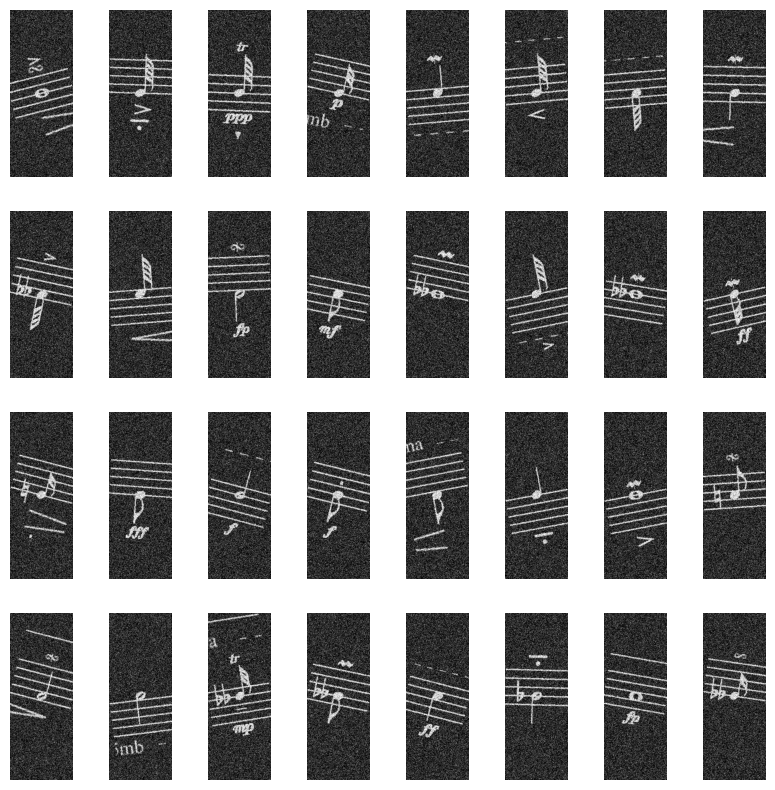

In [16]:
# 데이터셋 생성
dataset = tf.data.Dataset.list_files(os.path.join(dataset_dir, '*.png'))

# map
dataset = dataset.map(make_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# map : rotate_image
dataset = dataset.map(rotate_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# map : add_noise
dataset = dataset.map(add_noise, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# filter
dataset = dataset.filter(filter_dataset)

# cache
dataset = dataset.cache()

# shuffle
dataset = dataset.shuffle(buffer_size=25000)

# repeat
dataset = dataset.repeat(3)

# train, validation
ds_validation = dataset.take(320).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
ds_train = dataset.skip(320).batch(32)

# 만들어진 데이터셋 확인
plot_images(ds_validation, 32)

# 모델 학습

In [ ]:
# 그래프 초기화
tf.keras.backend.clear_session()

# 모델 생성 및 학습
with tf.device('/device:GPU:0'):
    # 모델 생성
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(192, 512, 1)))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPool2D(2, 2))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(32, activation='relu'))
    model.add(tf.keras.layers.Dense(11, activation='softmax'))

    # 모델 컴파일
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    # 모델 학습
    model.fit(ds_train, epochs=4, validation_data=ds_validation)